In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyyaml==5.1
# Версия torch 1.9.0
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# 
# Инструкции https://detectron2.readthedocs.io/tutorials/install.html 
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
##### ПЕРЕЗАПУСТИТЕ СРЕДУ ####

In [1]:
# Проверка версий
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9") 

1.9.0+cu102 True


In [ ]:
import os
from os.path import isfile, join
from tqdm import tqdm
import copy

In [2]:
# Устанавливаем логгер для детектрона
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Импорты
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
# Используем дефолтный конфиг
cfg = get_cfg()

# Загружаем конфиг для модели YouTubeVIS 2021 R50
# model = model_zoo.get("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml", trained=True)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"))

# Устанавливаем порог для детекции: если уровень доверия меньше порога, детекция не состоится
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# Загружаем модель
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")

# Создаем объект предиктора
predictor = DefaultPredictor(cfg)

model_final_a2914c.pkl: 220MB [00:07, 28.5MB/s]                           


In [ ]:
# функция добавляет по бокам картинки дополнительные пиксели
def frame_photo(path_photo, n):
    img = cv2.imread(path_photo) 
    new_img = np.array([])
    color_num = len(img[0][0])
    for i in range(len(img)):
        pix_first = img[i][0]
        pix_last = img[i][-1]
        line = img[i]
        for j in range(n):
            line = np.append(line, pix_last)
            line = np.insert(line, 0, pix_first)
        line = line.reshape(len(img[i]) + (n * 2), color_num)
        new_img = np.append(new_img, line)
    new_img = new_img.reshape(len(img), len(line), color_num)  
    cv2.imwrite("new_img.png", new_img)
    return

In [ ]:
def getFrame(sec, frame_out):
    "функция достает кадр и записывает в папку frame_out"
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite(frame_out + "/image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

In [ ]:
def put_on_mask(masks, im, elbrus):
  "для масок ставит картину"
  for ind, mask in enumerate(masks):
    mask = mask.to('cpu').numpy()
    
    #ставим рекламу в фото
    left_high_dot, left_low_dot, right_high_dot, right_low_dot  = sorted(find_contour(mask), key = lambda x:x[0])
    if left_high_dot[1] > left_low_dot[1]:
        left_high_dot, left_low_dot = left_low_dot, left_high_dot
    if right_high_dot[1] > right_low_dot[1]:
        right_high_dot, righ_low_dot = right_low_dot, right_high_dot


    h, w = abs(left_high_dot[1] - left_low_dot[1]), abs(left_high_dot[0] - right_high_dot[0])
    im.paste(
        elbrus.resize((w, h)),
        tuple(left_high_dot))
    
  return im

In [ ]:
def ads_video(pathIn, files, ads_photo):
    "функция получает папку, где лежат кадры, список кадров и рекламное фото"
    for i in tqdm(range(len(files))):
        "переписываем фото с рекламой"

        filename=pathIn + files[i]
        #reading each files
        im = filename
        
        with Image.open(im) as im:
            im.load()

        size = im.size

        #PIL to cv2
        img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)

        outputs = predictor(img)
        object_list = [ind for ind, val in enumerate(outputs['instances'].pred_classes.tolist()) if val == 62]
        masks = outputs['instances'].pred_masks[object_list]
        
        im = put_on_mask(masks, im, ads_photo)
          
        im.save(f'/content/drive/MyDrive/shots/shot_{i}.jpg')

        img_ads = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
        
        if i%100 == 0:
            cv2_imshow(img_ads)
    return

In [ ]:
#путь до видео и читаем видео

path = '/content/drive/MyDrive/Colab Notebooks/video.MOV'
vidcap = cv2.VideoCapture(path)

#путь до папки с кадрами
frame_out = 'images2'
# os.mkdir(frame_out)

frameRate = 0.1 #//it will capture image in each 0.1 second

#происходит раскадровка в папку
sec = 0
count=1
success = getFrame(sec, frame_out)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec, frame_out)


#список имён кадров
files = [f for f in os.listdir(frame_out) if isfile(join(frame_out, f))]
#сортируем, чтобы они шли 1, 2, 3 ...
files = sorted(files, key = lambda x: int(x.split('.')[0][5:]))

In [ ]:
path_video_out = '/content/drive/MyDrive/video3.mp4'
ads_video('/content/images2/', files, elbrus)

In [3]:
# Загружаем картинку и распечатываем
# !wget https://www.nxsttv.com/nmw/wp-content/uploads/sites/107/2021/06/DeltaPlaneGettyImages-1170328686-e1623504953879.jpg -q -O input.jpg
path_im = '/content/drive/MyDrive/Colab Notebooks/kover.jpg'
im = cv2.imread(path_im)
cv2_imshow(im)

Output hidden; open in https://colab.research.google.com to view.

In [5]:
# Передаем в объект загруженное выше изображение
outputs = predictor(im)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


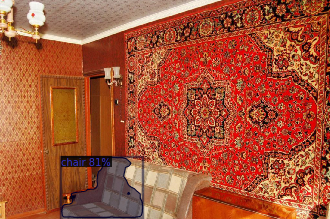

In [6]:
# Визуализируем  
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.3) # 
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [7]:
outputs['instances']

Instances(num_instances=1, image_height=733, image_width=1100, fields=[pred_boxes: Boxes(tensor([[204.3077, 525.0411, 477.1640, 729.6194]], device='cuda:0')), scores: tensor([0.8114], device='cuda:0'), pred_classes: tensor([56], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
x = outputs['instances'].pred_masks[0].to('cpu').numpy()
x.shape

(733, 1100)

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

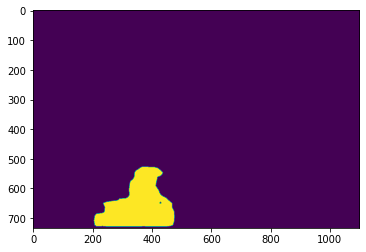

In [11]:
plt.imshow(x)

In [ ]:
cv2_imshow(np.array(im)[:,:,0] * np.array(x))

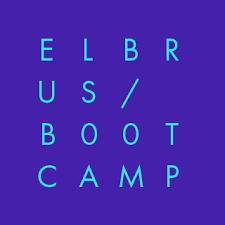

In [13]:
elbrus = cv2.imread("/content/drive/MyDrive/Colab Notebooks/elbrus.png")
cv2_imshow(elbrus)

In [15]:
def printMaxSubSquare(M):
  R = len(M) # no. of rows in M[][]
  C = len(M[0]) # no. of columns in M[][]

  S = []
  
  # Find the maximum entry and
  # indices of maximum entry in S[][]

  max_of_s = 0 # максимальная первая
  max_i, max_j = 0, 0  # правая, нижняя координата квадрата
  

  # Слева и сверху матрицы переносим числа (O(2*R)) 
  for i in range(R): # O(R^2)
    temp = []
    for j in range(C):
      if i==0 or j==0:
        temp += M[i][j],
        if max_of_s < M[i][j]:
          max_of_s = M[i][j]
          max_i, max_j = i, j
      else:
        temp += 0,
    S += temp,

  #Заполняет соседними числами O((R-1)^2)
  for i in range(1, R):
      for j in range(1, C):
          if (M[i][j] == 1):
              S[i][j] = min(S[i][j-1], S[i-1][j],
                          S[i-1][j-1]) + 1
          else:
              S[i][j] = 0
          if max_of_s < S[i][j]:
            max_of_s = S[i][j]
            max_i = i
            max_j = j
  

  # правая, нижняя координата прямоугольника
  max_i_2 = R - 1 - np.argmax(np.array(S)[:, max_j][::-1])
  max_j_2 = C - 1 - np.argmax(S[max_i][::-1])

  h, w = max_of_s + abs(max_i_2 - max_i), max_of_s + abs(max_j_2 - max_j)
  
  if max_of_s > 1:
    max_i -= max_of_s - 1
    max_j -= max_of_s - 1

  return max_j, max_i, h, w
  
# Driver Program
M = [[0, 1, 1, 0, 1],
    [1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0]]
printMaxSubSquare(M)


(1, 2, 3, 3)

In [ ]:
x_coor, y_coor, h, w = printMaxSubSquare(x)

im.paste(
    elbrus.resize((h, w)),
    (x_coor,y_coor))
im

In [66]:
def find_contour(mask):
    "Находит максимальный контур для маски и возвращает точки многоугольника"
    img = (255*np.array(mask)).astype(np.uint8)

    img = cv2.GaussianBlur(img, (5, 5), 0)
  
    thrs = 64 # определяет, какой формы искать объекты
    retval, bin = cv2.threshold(img, thrs, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) ## cv2.RETR_EXTERNAL 

    max=0
    sel_contour=None
    sel_contour = sorted(contours, key = lambda x: x.shape[0])[-1]

    hull = cv2.convexHull(sel_contour)

    rect = cv2.minAreaRect(hull) # center (x, y), (w, h), angle
    box = cv2.boxPoints(rect) # 4 точки 
    box = box.astype(int)

    # cv2_imshow(cv2.drawContours(np.array(im), [sel_contour], -1, (255,255,255), 1))
    return box

In [27]:
# Загружаем картинку и распечатываем
# !wget https://www.nxsttv.com/nmw/wp-content/uploads/sites/107/2021/06/DeltaPlaneGettyImages-1170328686-e1623504953879.jpg -q -O input.jpg
path_im = '/content/drive/MyDrive/Colab Notebooks/kover.jpg'
im = cv2.imread(path_im)

mask = outputs['instances'].pred_masks[0].to('cpu').numpy()

In [31]:
contour = find_contour(mask)

Output hidden; open in https://colab.research.google.com to view.

In [68]:
hull.shape

(35, 1, 2)

In [65]:
hull = cv2.convexHull(contour)
cv2_imshow(cv2.drawContours(np.array(im), [hull], -1, (255,255,255), 1))

Output hidden; open in https://colab.research.google.com to view.

In [51]:
(x,y,w,h) = cv2.boundingRect(hull)
cv2_imshow(cv2.rectangle(im.copy(), (x,y), (x+w,y+h), (0,255,0), 2))

Output hidden; open in https://colab.research.google.com to view.

In [52]:
rect = cv2.minAreaRect(hull) # center (x, y), (w, h), angle
box = cv2.boxPoints(rect) # 4 точки 
box = box.astype(int)
cv2_imshow(cv2.drawContours(im.copy(),[box],0,(0,0,255),2))

Output hidden; open in https://colab.research.google.com to view.

In [53]:
img = (255*np.array(mask)).astype(np.uint8)

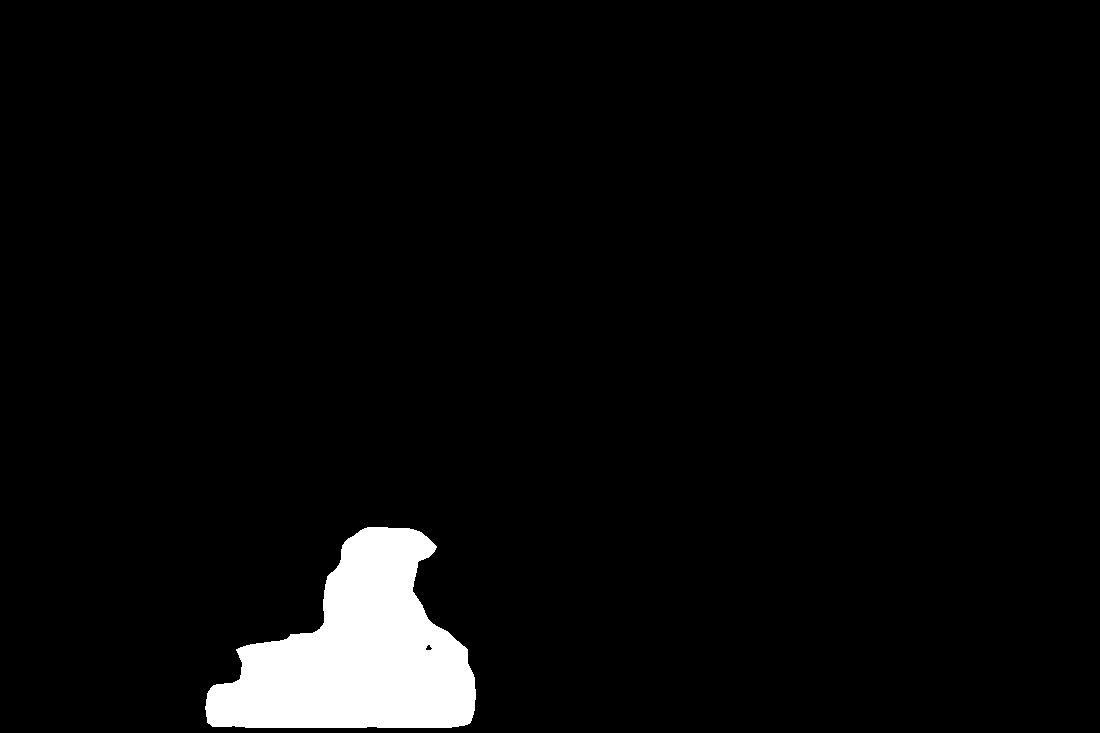

In [54]:
cv2_imshow(img)

In [224]:
squares = find_squares((255*np.array(x)).astype(np.uint8))

Output hidden; open in https://colab.research.google.com to view.

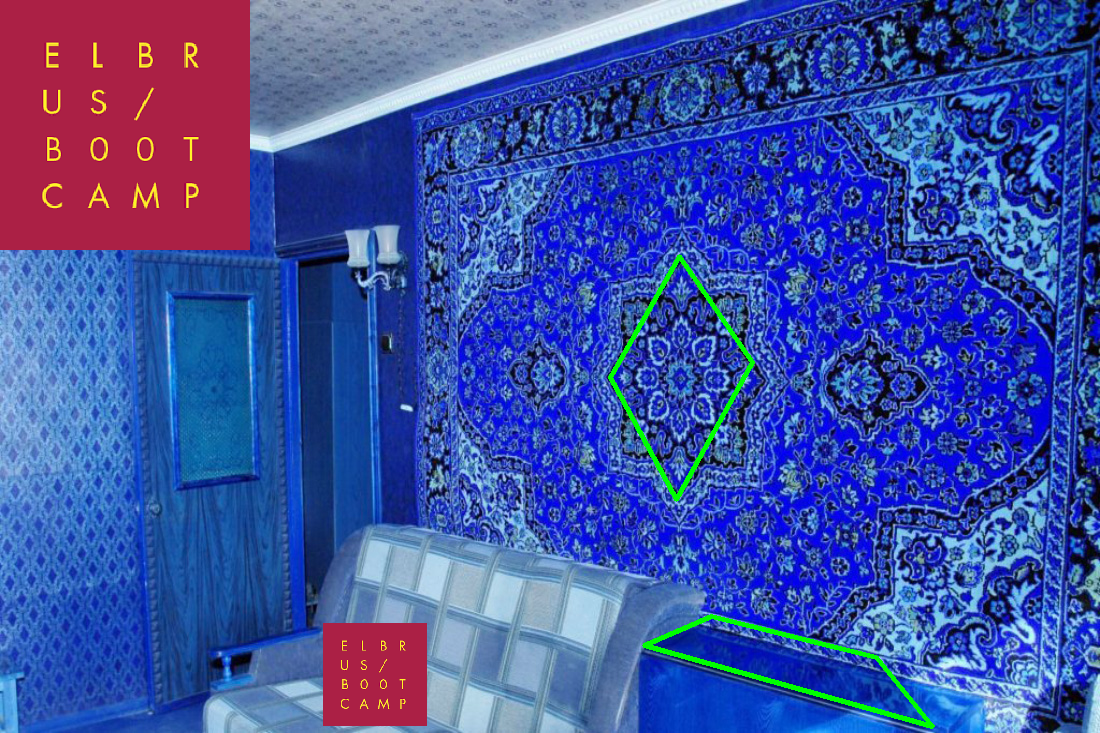

In [75]:
cv2_imshow(cv2.drawContours(np.array(im), squares, -1, (0,255,0), 3)